In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Global config and shared model

In [21]:
N = 24               # 24-hour horizon
dt = 1.0             # 1-hour time step
S0 = 5.0             # initial parent's sleep debt
H0 = 3.0             # initial infant hunger

# Model parameters (rates)
ALPHA = 1.0          # parent's sleep debt decrease rate when asleep
BETA  = 1.5          # parent's sleep debt increase rate when awake
GAMMA = 2.0          # infant hunger increase rate when not fed
DELTA = 3.0          # infant hunger decrease rate when fed

# Objective weights
W_SLEEP  = 1.0
W_HUNGER = 2.0

# Additional penalty for feeding at night (hours <6 or >=22)
NIGHT_FEEDING_PENALTY = 10.0

Helper: Day/Night Feeding Averages

In [22]:
def compute_day_night_feeding(f):
    """
    Given f[k] for k=0..N-1, return (avg_day, avg_night).
    Day: hours 6..21, Night: hours 0..5 and 22..23.
    """
    day_indices = [k for k in range(N) if 6 <= k < 22]
    night_indices = [k for k in range(N) if k < 6 or k >= 22]
    avg_day = np.mean([f[k] for k in day_indices]) if day_indices else 0.0
    avg_night = np.mean([f[k] for k in night_indices]) if night_indices else 0.0
    return avg_day, avg_night

Single-Parent On-Demand: Direct Shooting

In [23]:
def simulate_day_single_on_demand(control):
    """
    Single-parent, on-demand feeding simulation.
    control: array of length 2*N: (u0, f0, u1, f1, ..., u_{N-1}, f_{N-1}).
    Returns: S (N+1), H (N+1), total_cost.
    """
    u = control[0::2]
    f = control[1::2]
    S = np.zeros(N+1)
    H = np.zeros(N+1)
    S[0] = S0
    H[0] = H0
    total_cost = 0.0
    for k in range(N):
        cost_k = W_SLEEP * S[k] + W_HUNGER * H[k]
        if k < 6 or k >= 22:
            cost_k += NIGHT_FEEDING_PENALTY * f[k]
        total_cost += cost_k * dt
        dS = (BETA*u[k] - ALPHA*(1 - u[k])) * dt
        dH = (GAMMA*(1 - f[k]) - DELTA*f[k]) * dt
        S[k+1] = max(0, S[k] + dS)
        H[k+1] = max(0, H[k] + dH)
    return S, H, total_cost

def objective_single_on_demand(control):
    _, _, cost_val = simulate_day_single_on_demand(control)
    return cost_val

def feeding_constraint_single_on_demand(control):
    u = control[0::2]
    f = control[1::2]
    return u - f  # Must be >= 0

Single-Parent Scheduled Feeding (fixed pattern)

In [24]:
def simulate_day_single_scheduled():
    """
    Scheduled feeding: feed for 1 hour every 3 hours.
    Set f[k]=1 at hours 0,3,6,...,21 and u[k]=1 at those times; u and f are 0 otherwise.
    """
    u = np.zeros(N)
    f = np.zeros(N)
    for start in range(0, N, 3):
        if start < N:
            u[start] = 1.0
            f[start] = 1.0
    S = np.zeros(N+1)
    H = np.zeros(N+1)
    S[0] = S0
    H[0] = H0
    total_cost = 0.0
    for k in range(N):
        cost_k = W_SLEEP * S[k] + W_HUNGER * H[k]
        if k < 6 or k >= 22:
            cost_k += NIGHT_FEEDING_PENALTY * f[k]
        total_cost += cost_k * dt
        dS = (BETA*u[k] - ALPHA*(1 - u[k])) * dt
        dH = (GAMMA*(1 - f[k]) - DELTA*f[k]) * dt
        S[k+1] = max(0, S[k] + dS)
        H[k+1] = max(0, H[k] + dH)
    return u, f, S, H, total_cost

Two-parent on-deman: Direct Shooting (Tracking Each Parent's Sleep Debt)

In [25]:
def simulate_day_two_on_demand(control):
    """
    Two-parent, on-demand feeding simulation.
    control: length 4*N: for each hour k, (u1[k], f1[k], u2[k], f2[k]).
    Returns: S_total (S1+S2, length N+1), H (N+1), total_cost.
    """
    u1 = control[0::4]
    f1 = control[1::4]
    u2 = control[2::4]
    f2 = control[3::4]
    S1 = np.zeros(N+1)
    S2 = np.zeros(N+1)
    H = np.zeros(N+1)
    S1[0] = S0; S2[0] = S0; H[0] = H0
    total_cost = 0.0
    for k in range(N):
        cost_k = W_SLEEP*(S1[k] + S2[k]) + W_HUNGER*H[k]
        if k < 6 or k >= 22:
            cost_k += NIGHT_FEEDING_PENALTY*(f1[k] + f2[k])
        total_cost += cost_k * dt
        dS1 = (BETA*u1[k] - ALPHA*(1 - u1[k])) * dt
        dS2 = (BETA*u2[k] - ALPHA*(1 - u2[k])) * dt
        S1[k+1] = max(0, S1[k] + dS1)
        S2[k+1] = max(0, S2[k] + dS2)
        feed_effect = min(1.0, f1[k] + f2[k])  # effective feeding
        dH = (GAMMA*(1 - feed_effect) - DELTA*feed_effect) * dt
        H[k+1] = max(0, H[k] + dH)
    S_total = S1 + S2
    return S_total, H, total_cost

Two-parent scheduled feeding: Direct Shooting (fixed pattern)

In [26]:
def simulate_day_two_scheduled():
    """
    Two-parent scheduled feeding: feed every 3 hours, alternating which parent feeds.
    For k = 0,3,6,...:
      - If (k // 3) is even, then Parent 1 feeds (u1=1, f1=1) and Parent 2 rests (u2=0, f2=0).
      - Otherwise, Parent 2 feeds (u2=1, f2=1) and Parent 1 rests (u1=0, f1=0).
    """
    u1 = np.zeros(N)
    f1 = np.zeros(N)
    u2 = np.zeros(N)
    f2 = np.zeros(N)
    for k in range(0, N, 3):
        if (k // 3) % 2 == 0:
            u1[k] = 1.0; f1[k] = 1.0; u2[k] = 0.0; f2[k] = 0.0
        else:
            u2[k] = 1.0; f2[k] = 1.0; u1[k] = 0.0; f1[k] = 0.0
    S1 = np.zeros(N+1)
    S2 = np.zeros(N+1)
    H = np.zeros(N+1)
    S1[0] = S0; S2[0] = S0; H[0] = H0
    total_cost = 0.0
    for k in range(N):
        cost_k = W_SLEEP*(S1[k] + S2[k]) + W_HUNGER*H[k]
        if k < 6 or k >= 22:
            cost_k += NIGHT_FEEDING_PENALTY*(f1[k] + f2[k])
        total_cost += cost_k * dt
        dS1 = (BETA*u1[k] - ALPHA*(1 - u1[k])) * dt
        dS2 = (BETA*u2[k] - ALPHA*(1 - u2[k])) * dt
        S1[k+1] = max(0, S1[k] + dS1)
        S2[k+1] = max(0, S2[k] + dS2)
        feed_effect = max(f1[k], f2[k])  # if either feeds, count as feeding hour
        dH = (GAMMA*(1 - feed_effect) - DELTA*feed_effect) * dt
        H[k+1] = max(0, H[k] + dH)
    S_total = S1 + S2
    return S_total, H, total_cost, u1, f1, u2, f2

Result Summary Functions

In [27]:
def compute_day_night_avg_feed(control, scenario):
    """
    Returns: (final_S, final_H, avg_day_feed, avg_night_feed, cost)
    Scenario options: 'single_on_demand', 'single_scheduled', 'two_on_demand', 'two_scheduled'
    """
    if scenario == 'single_on_demand':
        S, H, cost = simulate_day_single_on_demand(control)
        f = control[1::2]
        avg_day, avg_night = compute_day_night_feeding(f)
        return S[-1], H[-1], avg_day, avg_night, cost
    elif scenario == 'single_scheduled':
        u, f, S, H, cost = simulate_day_single_scheduled()
        avg_day, avg_night = compute_day_night_feeding(f)
        return S[-1], H[-1], avg_day, avg_night, cost
    elif scenario == 'two_on_demand':
        S_tot, H, cost = simulate_day_two_on_demand(control)
        f1 = control[1::4]
        f2 = control[3::4]
        avg_day, avg_night = compute_day_night_feeding(f1 + f2)
        return S_tot[-1], H[-1], avg_day, avg_night, cost
    elif scenario == 'two_scheduled':
        S_tot, H, cost, u1, f1, u2, f2 = simulate_day_two_scheduled()
        avg_day, avg_night = compute_day_night_feeding(f1 + f2)
        return S_tot[-1], H[-1], avg_day, avg_night, cost
    else:
        return None

def print_results_table(results):
    print("\n--- SCENARIO RESULTS ---")
    print("Method | Parents | Feeding     |   S(T)  |  H(T)  |  Feed Day | Feed Night |  Cost")
    for row in results:
        print(f"{row[0]:<5} | {row[1]:<6} | {row[2]:<11} | {row[3]:7.3f} | {row[4]:6.3f} | {row[5]:9.3f} | {row[6]:10.3f} | {row[7]:8.3f}")

Initial Guess Functions

In [28]:
def initial_guess_shooting():
    guess = np.zeros(2*N)
    for k in range(N):
        guess[2*k] = 1.0      # u[k]
        guess[2*k+1] = 0.5    # f[k]
    return guess

def initial_guess_collocation():
    S_guess = np.full(N+1, S0)
    H_guess = np.full(N+1, H0)
    u_guess = np.ones(N)
    f_guess = 0.5 * np.ones(N)
    return np.concatenate([S_guess, H_guess, u_guess, f_guess])

def initial_guess_two_parent_shooting():
    x = np.zeros(4*N)
    for k in range(N):
        x[4*k]   = 1.0      # u1
        x[4*k+1] = 0.5      # f1
        x[4*k+2] = 1.0      # u2
        x[4*k+3] = 0.5      # f2
    return x

def initial_guess_two_parent_colloc():
    S1_guess = np.full(N+1, S0)
    S2_guess = np.full(N+1, S0)
    H_guess  = np.full(N+1, H0)
    u1_guess = np.ones(N)
    u2_guess = np.ones(N)
    f1_guess = 0.5*np.ones(N)
    f2_guess = 0.5*np.ones(N)
    return np.concatenate([S1_guess, S2_guess, H_guess, u1_guess, u2_guess, f1_guess, f2_guess])

Collocation Constraints (Single-Parent)

In [29]:
def unpack_colloc(z):
    S = z[0:(N+1)]
    H = z[(N+1):(2*N+2)]
    u = z[(2*N+2):(3*N+2)]
    f = z[(3*N+2):(4*N+2)]
    return S, H, u, f

def objective_collocation(z):
    S, H, u, f = unpack_colloc(z)
    cost = 0.0
    for k in range(N):
        cost_k = W_SLEEP * S[k] + W_HUNGER * H[k]
        if k < 6 or k >= 22:
            cost_k += NIGHT_FEEDING_PENALTY * f[k]
        cost += cost_k * dt
    return cost

def collocation_constraints(z):
    cons = []
    S, H, u, f = unpack_colloc(z)
    for k in range(N):
        def s_dyn(z, k=k):
            S_, H_, u_, f_ = unpack_colloc(z)
            return S_[k+1] - (S_[k] + dt*(BETA*u_[k] - ALPHA*(1-u_[k])))
        def h_dyn(z, k=k):
            S_, H_, u_, f_ = unpack_colloc(z)
            return H_[k+1] - (H_[k] + dt*(GAMMA*(1-f_[k]) - DELTA*f_[k]))
        cons.append({'type':'eq', 'fun': s_dyn})
        cons.append({'type':'eq', 'fun': h_dyn})
    def init_S(z):
        S_, _, _, _ = unpack_colloc(z)
        return S_[0] - S0
    def init_H(z):
        _, H_, _, _ = unpack_colloc(z)
        return H_[0] - H0
    cons.append({'type':'eq', 'fun': init_S})
    cons.append({'type':'eq', 'fun': init_H})
    return cons

def path_constraints_colloc(z):
    S, H, u, f = unpack_colloc(z)
    return u - f

def build_constraints_collocation():
    eq_cons = collocation_constraints(np.zeros(4*N+2))
    ineq_cons = {'type': 'ineq', 'fun': path_constraints_colloc}
    return eq_cons + [ineq_cons]

def build_bounds_collocation():
    bS = [(0,None)]*(N+1)
    bH = [(0,None)]*(N+1)
    bU = [(0,1)]*N
    bF = [(0,1)]*N
    return bS + bH + bU + bF

Two-parent Coligation (on-demand) - Direct Collocation

In [30]:
def unpack_two_parent_colloc(z):
    S1 = z[0:(N+1)]
    S2 = z[(N+1):(2*N+2)]
    H  = z[(2*N+2):(3*N+3)]
    u1 = z[(3*N+3):(4*N+3)]
    u2 = z[(4*N+3):(5*N+3)]
    f1 = z[(5*N+3):(6*N+3)]
    f2 = z[(6*N+3):(7*N+3)]
    return S1, S2, H, u1, u2, f1, f2

def objective_two_parent_colloc(z):
    S1, S2, H, u1, u2, f1, f2 = unpack_two_parent_colloc(z)
    cost = 0.0
    for k in range(N):
        cost_k = W_SLEEP*(S1[k] + S2[k]) + W_HUNGER*H[k]
        if k < 6 or k >= 22:
            cost_k += NIGHT_FEEDING_PENALTY*(f1[k]+f2[k])
        cost += cost_k*dt
    return cost

def collocation_constraints_two_parent(z):
    cons = []
    S1, S2, H, u1, u2, f1, f2 = unpack_two_parent_colloc(z)
    for k in range(N):
        def s1_dyn(z, k=k):
            S1_, S2_, H_, u1_, u2_, f1_, f2_ = unpack_two_parent_colloc(z)
            return S1_[k+1] - (S1_[k] + dt*(BETA*u1_[k] - ALPHA*(1-u1_[k])))
        def s2_dyn(z, k=k):
            S1_, S2_, H_, u1_, u2_, f1_, f2_ = unpack_two_parent_colloc(z)
            return S2_[k+1] - (S2_[k] + dt*(BETA*u2_[k] - ALPHA*(1-u2_[k])))
        def h_dyn(z, k=k):
            S1_, S2_, H_, u1_, u2_, f1_, f2_ = unpack_two_parent_colloc(z)
            feed_effect = min(1.0, f1_[k]+f2_[k])
            return H_[k+1] - (H_[k] + dt*(GAMMA*(1-feed_effect) - DELTA*feed_effect))
        cons.append({'type':'eq', 'fun': s1_dyn})
        cons.append({'type':'eq', 'fun': s2_dyn})
        cons.append({'type':'eq', 'fun': h_dyn})
    def init_S1(z):
        S1_, _, _, _, _, _, _ = unpack_two_parent_colloc(z)
        return S1_[0] - S0
    def init_S2(z):
        _, S2_, _, _, _, _, _ = unpack_two_parent_colloc(z)
        return S2_[0] - S0
    def init_H(z):
        _, _, H_, _, _, _, _ = unpack_two_parent_colloc(z)
        return H_[0] - H0
    cons.append({'type':'eq', 'fun': init_S1})
    cons.append({'type':'eq', 'fun': init_S2})
    cons.append({'type':'eq', 'fun': init_H})
    return cons

def path_constraints_two_parent(z):
    S1, S2, H, u1, u2, f1, f2 = unpack_two_parent_colloc(z)
    arr = []
    for k in range(N):
        arr.append(u1[k]-f1[k])
        arr.append(u2[k]-f2[k])
        arr.append(1.0 - (f1[k]+f2[k]))
    return np.array(arr)

def build_constraints_two_parent_colloc():
    eq_cons = collocation_constraints_two_parent(np.zeros(7*N+3))
    ineq_cons = {'type': 'ineq', 'fun': path_constraints_two_parent}
    return eq_cons + [ineq_cons]

def build_bounds_two_parent_colloc():
    bS1 = [(0,None)]*(N+1)
    bS2 = [(0,None)]*(N+1)
    bH  = [(0,None)]*(N+1)
    bU1 = [(0,1)]*N
    bU2 = [(0,1)]*N
    bF1 = [(0,1)]*N
    bF2 = [(0,1)]*N
    return bS1 + bS2 + bH + bU1 + bU2 + bF1 + bF2

Two-parent Scheduled Feeding: Direct Shooting (Fixed Pattern)

In [31]:
def simulate_day_two_scheduled():
    """
    Two-parent scheduled feeding: feed every 3 hours, alternating which parent feeds.
    For k = 0,3,6,...:
      - If (k // 3) is even, then Parent 1 feeds (u1=1, f1=1), Parent 2 rests (u2=0, f2=0).
      - Otherwise, Parent 2 feeds (u2=1, f2=1), Parent 1 rests (u1=0, f1=0).
    """
    u1 = np.zeros(N)
    f1 = np.zeros(N)
    u2 = np.zeros(N)
    f2 = np.zeros(N)
    for k in range(0, N, 3):
        if (k // 3) % 2 == 0:
            u1[k] = 1.0; f1[k] = 1.0; u2[k] = 0.0; f2[k] = 0.0
        else:
            u2[k] = 1.0; f2[k] = 1.0; u1[k] = 0.0; f1[k] = 0.0
    S1 = np.zeros(N+1)
    S2 = np.zeros(N+1)
    H = np.zeros(N+1)
    S1[0] = S0; S2[0] = S0; H[0] = H0
    total_cost = 0.0
    for k in range(N):
        cost_k = W_SLEEP*(S1[k]+S2[k]) + W_HUNGER*H[k]
        if k < 6 or k >= 22:
            cost_k += NIGHT_FEEDING_PENALTY*(f1[k]+f2[k])
        total_cost += cost_k*dt
        dS1 = (BETA*u1[k] - ALPHA*(1-u1[k]))*dt
        dS2 = (BETA*u2[k] - ALPHA*(1-u2[k]))*dt
        S1[k+1] = max(0, S1[k]+dS1)
        S2[k+1] = max(0, S2[k]+dS2)
        feed_effect = max(f1[k], f2[k])  # if either feeds, count as feeding
        dH = (GAMMA*(1-feed_effect) - DELTA*feed_effect)*dt
        H[k+1] = max(0, H[k]+dH)
    S_total = S1 + S2
    return S_total, H, total_cost, u1, f1, u2, f2

Result Summary Functions

In [32]:
def compute_day_night_avg_feed(control, scenario):
    """
    Returns: (final_S, final_H, avg_feed_day, avg_feed_night, cost)
    Scenario options:
      'single_on_demand', 'single_scheduled', 'two_on_demand', 'two_scheduled'
    """
    if scenario == 'single_on_demand':
        S, H, cost = simulate_day_single_on_demand(control)
        f = control[1::2]
        avg_day, avg_night = compute_day_night_feeding(f)
        return S[-1], H[-1], avg_day, avg_night, cost
    elif scenario == 'single_scheduled':
        u, f, S, H, cost = simulate_day_single_scheduled()
        avg_day, avg_night = compute_day_night_feeding(f)
        return S[-1], H[-1], avg_day, avg_night, cost
    elif scenario == 'two_on_demand':
        S_tot, H, cost = simulate_day_two_on_demand(control)
        f1 = control[1::4]
        f2 = control[3::4]
        avg_day, avg_night = compute_day_night_feeding(f1+f2)
        return S_tot[-1], H[-1], avg_day, avg_night, cost
    elif scenario == 'two_scheduled':
        S_tot, H, cost, u1, f1, u2, f2 = simulate_day_two_scheduled()
        avg_day, avg_night = compute_day_night_feeding(f1+f2)
        return S_tot[-1], H[-1], avg_day, avg_night, cost
    else:
        return None

def print_results_table(results):
    print("\n--- SCENARIO RESULTS ---")
    print("Method | Parents | Feeding     |   S(T)  |  H(T)  |  Feed Day | Feed Night |  Cost")
    for row in results:
        print(f"{row[0]:<5} | {row[1]:<6} | {row[2]:<11} | {row[3]:7.3f} | {row[4]:6.3f} | {row[5]:9.3f} | {row[6]:10.3f} | {row[7]:8.3f}")

Initial Guess Functions

In [33]:
def initial_guess_shooting():
    guess = np.zeros(2*N)
    for k in range(N):
        guess[2*k] = 1.0
        guess[2*k+1] = 0.5
    return guess

def initial_guess_collocation():
    S_guess = np.full(N+1, S0)
    H_guess = np.full(N+1, H0)
    u_guess = np.ones(N)
    f_guess = 0.5 * np.ones(N)
    return np.concatenate([S_guess, H_guess, u_guess, f_guess])

def initial_guess_two_parent_shooting():
    x = np.zeros(4*N)
    for k in range(N):
        x[4*k]   = 1.0     # u1
        x[4*k+1] = 0.5     # f1
        x[4*k+2] = 1.0     # u2
        x[4*k+3] = 0.5     # f2
    return x

def initial_guess_two_parent_colloc():
    S1_guess = np.full(N+1, S0)
    S2_guess = np.full(N+1, S0)
    H_guess  = np.full(N+1, H0)
    u1_guess = np.ones(N)
    u2_guess = np.ones(N)
    f1_guess = 0.5*np.ones(N)
    f2_guess = 0.5*np.ones(N)
    return np.concatenate([S1_guess, S2_guess, H_guess, u1_guess, u2_guess, f1_guess, f2_guess])

Colligation Constraints (Single-Parent)

In [34]:
def unpack_colloc(z):
    S = z[0:(N+1)]
    H = z[(N+1):(2*N+2)]
    u = z[(2*N+2):(3*N+2)]
    f = z[(3*N+2):(4*N+2)]
    return S, H, u, f

def objective_collocation(z):
    S, H, u, f = unpack_colloc(z)
    cost = 0.0
    for k in range(N):
        cost_k = W_SLEEP * S[k] + W_HUNGER * H[k]
        if k < 6 or k >= 22:
            cost_k += NIGHT_FEEDING_PENALTY * f[k]
        cost += cost_k * dt
    return cost

def collocation_constraints(z):
    cons = []
    S, H, u, f = unpack_colloc(z)
    for k in range(N):
        def s_dyn(z, k=k):
            S_, H_, u_, f_ = unpack_colloc(z)
            return S_[k+1] - (S_[k] + dt*(BETA*u_[k] - ALPHA*(1-u_[k])))
        def h_dyn(z, k=k):
            S_, H_, u_, f_ = unpack_colloc(z)
            return H_[k+1] - (H_[k] + dt*(GAMMA*(1-f_[k]) - DELTA*f_[k]))
        cons.append({'type':'eq', 'fun': s_dyn})
        cons.append({'type':'eq', 'fun': h_dyn})
    def init_S(z):
        S_, _, _, _ = unpack_colloc(z)
        return S_[0] - S0
    def init_H(z):
        _, H_, _, _ = unpack_colloc(z)
        return H_[0] - H0
    cons.append({'type':'eq', 'fun': init_S})
    cons.append({'type':'eq', 'fun': init_H})
    return cons

def path_constraints_colloc(z):
    S, H, u, f = unpack_colloc(z)
    return u - f

def build_constraints_collocation():
    eq_cons = collocation_constraints(np.zeros(4*N+2))
    ineq_cons = {'type': 'ineq', 'fun': path_constraints_colloc}
    return eq_cons + [ineq_cons]

def build_bounds_collocation():
    bS = [(0,None)]*(N+1)
    bH = [(0,None)]*(N+1)
    bU = [(0,1)]*N
    bF = [(0,1)]*N
    return bS + bH + bU + bF

Two-parent Colligation (On-Demand) - Direct Collocation

In [35]:
def unpack_two_parent_colloc(z):
    S1 = z[0:(N+1)]
    S2 = z[(N+1):(2*N+2)]
    H  = z[(2*N+2):(3*N+3)]
    u1 = z[(3*N+3):(4*N+3)]
    u2 = z[(4*N+3):(5*N+3)]
    f1 = z[(5*N+3):(6*N+3)]
    f2 = z[(6*N+3):(7*N+3)]
    return S1, S2, H, u1, u2, f1, f2

def objective_two_parent_colloc(z):
    S1, S2, H, u1, u2, f1, f2 = unpack_two_parent_colloc(z)
    cost = 0.0
    for k in range(N):
        cost_k = W_SLEEP*(S1[k] + S2[k]) + W_HUNGER*H[k]
        if k < 6 or k >= 22:
            cost_k += NIGHT_FEEDING_PENALTY*(f1[k] + f2[k])
        cost += cost_k*dt
    return cost

def collocation_constraints_two_parent(z):
    cons = []
    S1, S2, H, u1, u2, f1, f2 = unpack_two_parent_colloc(z)
    for k in range(N):
        def s1_dyn(z, k=k):
            S1_, S2_, H_, u1_, u2_, f1_, f2_ = unpack_two_parent_colloc(z)
            return S1_[k+1] - (S1_[k] + dt*(BETA*u1_[k] - ALPHA*(1-u1_[k])))
        def s2_dyn(z, k=k):
            S1_, S2_, H_, u1_, u2_, f1_, f2_ = unpack_two_parent_colloc(z)
            return S2_[k+1] - (S2_[k] + dt*(BETA*u2_[k] - ALPHA*(1-u2_[k])))
        def h_dyn(z, k=k):
            S1_, S2_, H_, u1_, u2_, f1_, f2_ = unpack_two_parent_colloc(z)
            feed_effect = min(1.0, f1_[k] + f2_[k])
            return H_[k+1] - (H_[k] + dt*(GAMMA*(1-feed_effect) - DELTA*feed_effect))
        cons.append({'type':'eq', 'fun': s1_dyn})
        cons.append({'type':'eq', 'fun': s2_dyn})
        cons.append({'type':'eq', 'fun': h_dyn})
    def init_S1(z):
        S1_, _, _, _, _, _, _ = unpack_two_parent_colloc(z)
        return S1_[0] - S0
    def init_S2(z):
        _, S2_, _, _, _, _, _ = unpack_two_parent_colloc(z)
        return S2_[0] - S0
    def init_H(z):
        _, _, H_, _, _, _, _ = unpack_two_parent_colloc(z)
        return H_[0] - H0
    cons.append({'type':'eq', 'fun': init_S1})
    cons.append({'type':'eq', 'fun': init_S2})
    cons.append({'type':'eq', 'fun': init_H})
    return cons

def path_constraints_two_parent(z):
    S1, S2, H, u1, u2, f1, f2 = unpack_two_parent_colloc(z)
    arr = []
    for k in range(N):
        arr.append(u1[k] - f1[k])
        arr.append(u2[k] - f2[k])
        arr.append(1.0 - (f1[k] + f2[k]))
    return np.array(arr)

def build_constraints_two_parent_colloc():
    eq_cons = collocation_constraints_two_parent(np.zeros(7*N+3))
    ineq_cons = {'type': 'ineq', 'fun': path_constraints_two_parent}
    return eq_cons + [ineq_cons]

def build_bounds_two_parent_colloc():
    bS1 = [(0,None)]*(N+1)
    bS2 = [(0,None)]*(N+1)
    bH  = [(0,None)]*(N+1)
    bU1 = [(0,1)]*N
    bU2 = [(0,1)]*N
    bF1 = [(0,1)]*N
    bF2 = [(0,1)]*N
    return bS1 + bS2 + bH + bU1 + bU2 + bF1 + bF2

Result Summary Functions

In [36]:
def compute_day_night_avg_feed(control, scenario):
    """
    Returns: (final_S, final_H, avg_feed_day, avg_feed_night, cost) for the scenario.
    Scenario options: 'single_on_demand', 'single_scheduled', 'two_on_demand', 'two_scheduled'
    """
    if scenario == 'single_on_demand':
        S, H, cost = simulate_day_single_on_demand(control)
        f = control[1::2]
        avg_day, avg_night = compute_day_night_feeding(f)
        return S[-1], H[-1], avg_day, avg_night, cost
    elif scenario == 'single_scheduled':
        u, f, S, H, cost = simulate_day_single_scheduled()
        avg_day, avg_night = compute_day_night_feeding(f)
        return S[-1], H[-1], avg_day, avg_night, cost
    elif scenario == 'two_on_demand':
        S_tot, H, cost = simulate_day_two_on_demand(control)
        f1 = control[1::4]
        f2 = control[3::4]
        avg_day, avg_night = compute_day_night_feeding(f1+f2)
        return S_tot[-1], H[-1], avg_day, avg_night, cost
    elif scenario == 'two_scheduled':
        S_tot, H, cost, u1, f1, u2, f2 = simulate_day_two_scheduled()
        avg_day, avg_night = compute_day_night_feeding(f1+f2)
        return S_tot[-1], H[-1], avg_day, avg_night, cost
    else:
        return None

def print_results_table(results):
    print("\n--- SCENARIO RESULTS ---")
    print("Method | Parents | Feeding     |   S(T)  |  H(T)  |  Feed Day | Feed Night |  Cost")
    for row in results:
        print(f"{row[0]:<5} | {row[1]:<6} | {row[2]:<11} | {row[3]:7.3f} | {row[4]:6.3f} | {row[5]:9.3f} | {row[6]:10.3f} | {row[7]:8.3f}")

Initial Guess Functions

In [37]:
def initial_guess_shooting():
    guess = np.zeros(2*N)
    for k in range(N):
        guess[2*k] = 1.0
        guess[2*k+1] = 0.5
    return guess

def initial_guess_collocation():
    S_guess = np.full(N+1, S0)
    H_guess = np.full(N+1, H0)
    u_guess = np.ones(N)
    f_guess = 0.5 * np.ones(N)
    return np.concatenate([S_guess, H_guess, u_guess, f_guess])

def initial_guess_two_parent_shooting():
    x = np.zeros(4*N)
    for k in range(N):
        x[4*k]   = 1.0      # u1
        x[4*k+1] = 0.5      # f1
        x[4*k+2] = 1.0      # u2
        x[4*k+3] = 0.5      # f2
    return x

def initial_guess_two_parent_colloc():
    S1_guess = np.full(N+1, S0)
    S2_guess = np.full(N+1, S0)
    H_guess  = np.full(N+1, H0)
    u1_guess = np.ones(N)
    u2_guess = np.ones(N)
    f1_guess = 0.5 * np.ones(N)
    f2_guess = 0.5 * np.ones(N)
    return np.concatenate([S1_guess, S2_guess, H_guess, u1_guess, u2_guess, f1_guess, f2_guess])

Main execution: Run Scenarios and Print Results Table

=== Direct Shooting ===
Optimization terminated successfully    (Exit mode 0)
            Current function value: 192.50117498514402
            Iterations: 95
            Function evaluations: 4838
            Gradient evaluations: 95
Shooting success: True Optimization terminated successfully
Shooting final cost: 192.50117498514402

=== Direct Collocation ===
Optimization terminated successfully    (Exit mode 0)
            Current function value: 192.50000000002163
            Iterations: 5
            Function evaluations: 495
            Gradient evaluations: 5
Collocation success: True Optimization terminated successfully
Collocation final cost: 192.50000000002163


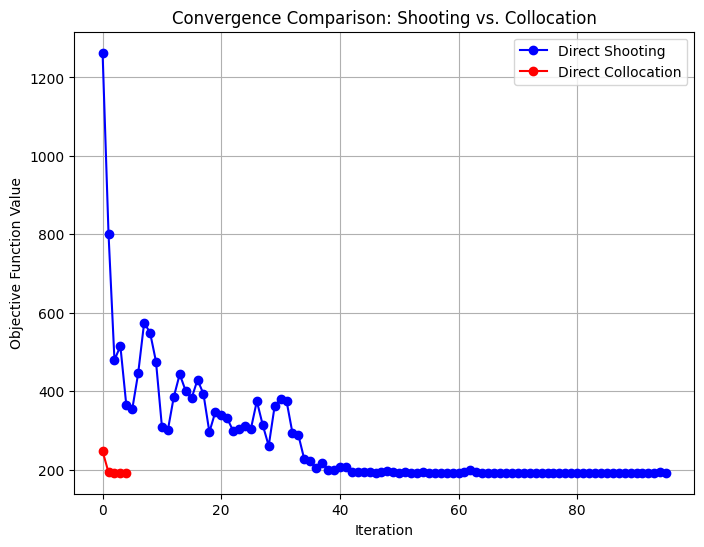


Convergence plot saved to 'convergence_plot.png'.
Running single_on_demand (shooting)...
Running single_on_demand (collocation)...
Running single_scheduled (fixed schedule)...
Running two_on_demand (shooting)...
Running two_on_demand (collocation)...
Running two_parent_scheduled (fixed schedule)...

--- SCENARIO RESULTS ---
Method | Parents | Feeding     |   S(T)  |  H(T)  |  Feed Day | Feed Night |  Cost
DS    | Single | On-Demand   |   7.000 |  4.000 |     0.425 |      0.325 |  192.501
DC    | Single | On-Demand   |   5.276 |  4.000 |     0.425 |      0.325 |  192.500
Manual | Single | Scheduled   |   1.000 | 11.000 |     0.375 |      0.250 |  362.000
DS    | Two    | On-Demand   |   3.000 |  3.026 |     0.437 |      0.349 |  109.501
DC    | Two    | On-Demand   |   0.000 |  3.811 |     0.425 |      0.330 |  114.434
Manual | Two    | Scheduled   |   0.000 | 11.000 |     0.375 |      0.250 |  335.000


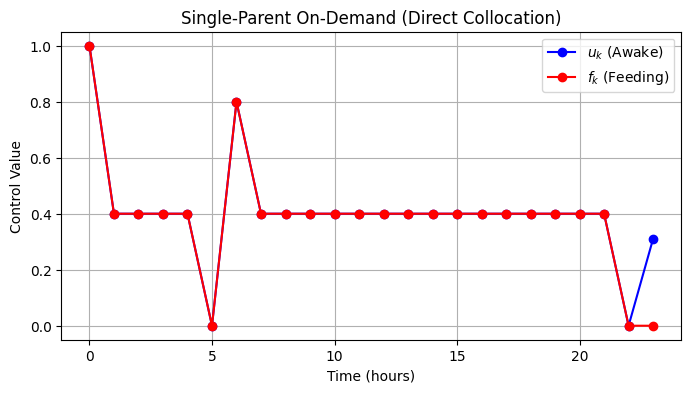

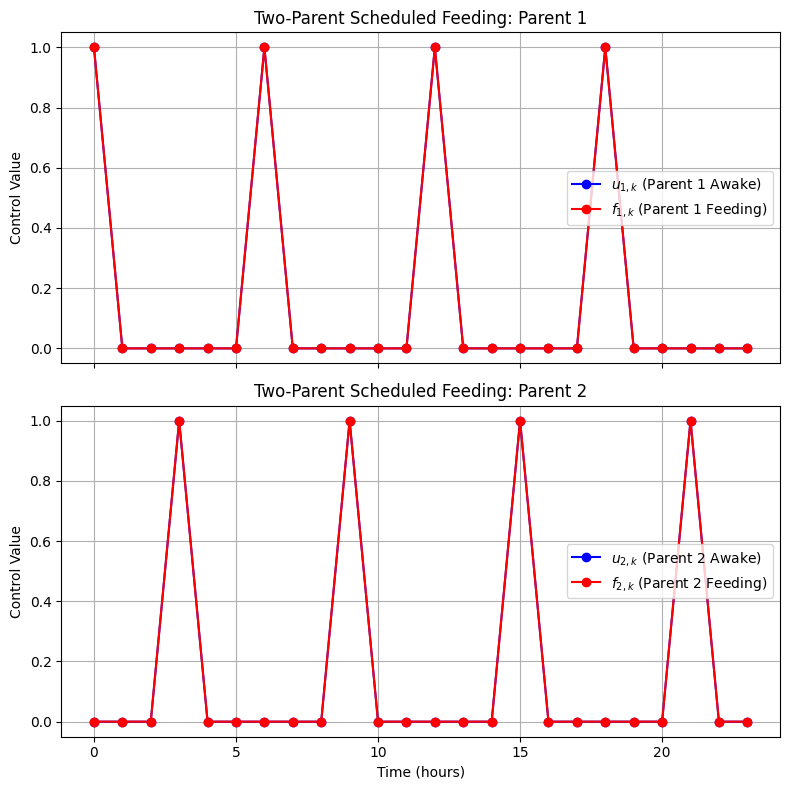

In [38]:
def run_scenarios():
    results = []

    # SINGLE ON-DEMAND (Direct Shooting)
    print("Running single_on_demand (shooting)...")
    x0 = initial_guess_shooting()
    cons_shoot = [{'type':'ineq','fun': feeding_constraint_single_on_demand}]
    bnds_shoot = [(0,1)]*(2*N)
    res_shoot = minimize(
        objective_single_on_demand,
        x0,
        method='SLSQP',
        bounds=bnds_shoot,
        constraints=cons_shoot,
        options={'maxiter':200, 'disp':False}
    )
    s_final, h_final, day_feed, night_feed, cost_shoot = compute_day_night_avg_feed(res_shoot.x, 'single_on_demand')
    results.append(("DS", "Single", "On-Demand", s_final, h_final, day_feed, night_feed, cost_shoot))

    # SINGLE ON-DEMAND (Direct Collocation)
    print("Running single_on_demand (collocation)...")
    z0_colloc = initial_guess_collocation()
    cons_colloc = build_constraints_collocation()
    bnds_colloc = build_bounds_collocation()
    res_colloc = minimize(
        objective_collocation,
        z0_colloc,
        method='SLSQP',
        bounds=bnds_colloc,
        constraints=cons_colloc,
        options={'maxiter':200, 'disp':False}
    )
    S_col, H_col, u_col, f_col = unpack_colloc(res_colloc.x)
    avg_day, avg_night = compute_day_night_feeding(f_col)
    results.append(("DC", "Single", "On-Demand", S_col[-1], H_col[-1], avg_day, avg_night, res_colloc.fun))

    # SINGLE SCHEDULED (Manual)
    print("Running single_scheduled (fixed schedule)...")
    s_sch, h_sch, day_sch, night_sch, cost_sch = compute_day_night_avg_feed(None, 'single_scheduled')
    results.append(("Manual", "Single", "Scheduled", s_sch, h_sch, day_sch, night_sch, cost_sch))

    # TWO-PARENT ON-DEMAND (Direct Shooting)
    print("Running two_on_demand (shooting)...")
    x0_two = initial_guess_two_parent_shooting()
    def two_parent_shoot_constraint(ctrl):
        u1 = ctrl[0::4]
        f1 = ctrl[1::4]
        u2 = ctrl[2::4]
        f2 = ctrl[3::4]
        arr = []
        for k in range(N):
            arr.append(u1[k]-f1[k])
            arr.append(u2[k]-f2[k])
            arr.append(1.0 - (f1[k]+f2[k]))
        return np.array(arr)
    cons_two = [{'type':'ineq', 'fun': two_parent_shoot_constraint}]
    bnds_two = [(0,1)]*(4*N)
    res_two = minimize(
        lambda ctrl: simulate_day_two_on_demand(ctrl)[2],
        x0_two,
        method='SLSQP',
        bounds=bnds_two,
        constraints=cons_two,
        options={'maxiter':200, 'disp':False}
    )
    s_two, h_two, day_two, night_two, cost_two = compute_day_night_avg_feed(res_two.x, 'two_on_demand')
    results.append(("DS", "Two", "On-Demand", s_two, h_two, day_two, night_two, cost_two))

    # TWO-PARENT ON-DEMAND (Direct Collocation)
    print("Running two_on_demand (collocation)...")
    z0_two_colloc = initial_guess_two_parent_colloc()
    cons_two_colloc = build_constraints_two_parent_colloc()
    bnds_two_colloc = build_bounds_two_parent_colloc()
    res_two_colloc = minimize(
        objective_two_parent_colloc,
        z0_two_colloc,
        method='SLSQP',
        bounds=bnds_two_colloc,
        constraints=cons_two_colloc,
        options={'maxiter':200, 'disp':False}
    )
    S1_col, S2_col, H_tp, u1_col, u2_col, f1_col, f2_col = unpack_two_parent_colloc(res_two_colloc.x)
    avg_day_two_col, avg_night_two_col = compute_day_night_feeding(f1_col+f2_col)
    S_tot_col = S1_col + S2_col
    results.append(("DC", "Two", "On-Demand", S_tot_col[-1], H_tp[-1], avg_day_two_col, avg_night_two_col, res_two_colloc.fun))

    # TWO-PARENT SCHEDULED (Manual)
    print("Running two_parent_scheduled (fixed schedule)...")
    S_sched_two, H_sched_two, cost_sched_two, u1_sched, f1_sched, u2_sched, f2_sched = simulate_day_two_scheduled()
    avg_day_two_sched, avg_night_two_sched = compute_day_night_feeding(f1_sched+f2_sched)
    results.append(("Manual", "Two", "Scheduled", S_sched_two[-1], H_sched_two[-1], avg_day_two_sched, avg_night_two_sched, cost_sched_two))

    print_results_table(results)
    return results

class IterLogger:
    def __init__(self, objective_func):
        self.obj_vals = []
        self.objective_func = objective_func

    def callback(self, xk):
        val = self.objective_func(xk)
        self.obj_vals.append(val)
        
def feeding_constraint_single(control):
    u = control[0::2]
    f = control[1::2]
    return u - f

def build_constraints_shooting():
    return [{'type':'ineq','fun': feeding_constraint_single}]

def build_bounds_shooting():
    return [(0,1)]*(2*N)

def objective_shooting(control):
    """Objective for direct shooting: total cost from simulate_day."""
    _, _, cost_val = simulate_day_single_on_demand(control)
    return cost_val

# 1) Direct Shooting
print("=== Direct Shooting ===")
x0_shooting = initial_guess_shooting()
cons_shooting = build_constraints_shooting()
bnds_shooting = build_bounds_shooting()

shooting_logger = IterLogger(objective_shooting)
def shooting_callback(xk):
    shooting_logger.callback(xk)

res_shooting = minimize(
    objective_shooting,
    x0_shooting,
    method='SLSQP',
    bounds=bnds_shooting,
    constraints=cons_shooting,
    callback=shooting_callback,
    options={'maxiter':200, 'disp':True}
)
print("Shooting success:", res_shooting.success, res_shooting.message)
print("Shooting final cost:", res_shooting.fun)
# final solution
S_sol_sh, H_sol_sh, cost_sol_sh = simulate_day_single_on_demand(res_shooting.x)

# 2) Direct Collocation
print("\n=== Direct Collocation ===")
z0_colloc = initial_guess_collocation()
cons_colloc = build_constraints_collocation()
bnds_colloc = build_bounds_collocation()

colloc_logger = IterLogger(objective_collocation)
def colloc_callback(xk):
    colloc_logger.callback(xk)

res_colloc = minimize(
    objective_collocation,
    z0_colloc,
    method='SLSQP',
    bounds=bnds_colloc,
    constraints=cons_colloc,
    callback=colloc_callback,
    options={'maxiter':200, 'disp':True}
)
print("Collocation success:", res_colloc.success, res_colloc.message)
print("Collocation final cost:", res_colloc.fun)

# final solution for collocation
S_opt, H_opt, u_opt, f_opt = unpack_colloc(res_colloc.x)

# Plot convergence
if len(shooting_logger.obj_vals) == 0:
    shooting_logger.obj_vals.append(res_shooting.fun)
elif shooting_logger.obj_vals[-1] != res_shooting.fun:
    shooting_logger.obj_vals.append(res_shooting.fun)

if len(colloc_logger.obj_vals) == 0:
    colloc_logger.obj_vals.append(res_colloc.fun)
elif colloc_logger.obj_vals[-1] != res_colloc.fun:
    colloc_logger.obj_vals.append(res_colloc.fun)

plt.figure(figsize=(8,6))
plt.plot(shooting_logger.obj_vals, 'bo-', label='Direct Shooting')
plt.plot(colloc_logger.obj_vals, 'ro-', label='Direct Collocation')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Convergence Comparison: Shooting vs. Collocation')
plt.grid(True)
plt.legend()
plt.savefig('convergence_plot.png', dpi=150)
plt.show()

print("\nConvergence plot saved to 'convergence_plot.png'.")
run_scenarios()

# Plot Control Trajectories for Illustrative Figure 
S_col, H_col, u_col, f_col = unpack_colloc(res_colloc.x)
time_single = np.arange(0, N)
plt.figure(figsize=(8,4))
plt.plot(time_single, u_col, 'b-o', label='$u_k$ (Awake)')
plt.plot(time_single, f_col, 'r-o', label='$f_k$ (Feeding)')
plt.xlabel('Time (hours)')
plt.ylabel('Control Value')
plt.title('Single-Parent On-Demand (Direct Collocation)')
plt.grid(True)
plt.legend()
plt.savefig("controls_single.png", dpi=150)
plt.show()

# 2. Two-Parent, Scheduled Feeding (Direct Shooting)
S_sched_two, H_sched_two, cost_sched_two, u1_sched, f1_sched, u2_sched, f2_sched = simulate_day_two_scheduled()
time_two = np.arange(0, N)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True)
ax1.plot(time_two, u1_sched, 'b-o', label='$u_{1,k}$ (Parent 1 Awake)')
ax1.plot(time_two, f1_sched, 'r-o', label='$f_{1,k}$ (Parent 1 Feeding)')
ax1.set_ylabel('Control Value')
ax1.set_title('Two-Parent Scheduled Feeding: Parent 1')
ax1.legend()
ax1.grid(True)
ax2.plot(time_two, u2_sched, 'b-o', label='$u_{2,k}$ (Parent 2 Awake)')
ax2.plot(time_two, f2_sched, 'r-o', label='$f_{2,k}$ (Parent 2 Feeding)')
ax2.set_xlabel('Time (hours)')
ax2.set_ylabel('Control Value')
ax2.set_title('Two-Parent Scheduled Feeding: Parent 2')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.savefig("controls_two.png", dpi=150)
plt.show()